In [91]:
import torch, torchvision
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import sklearn
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [92]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [93]:
class TitanicDataSet(torch.utils.data.Dataset):
    def __init__(self, csv_file: str, train: bool):
        original_frame = pd.read_csv(csv_file)
        
        feature_frame = original_frame[["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex", "Embarked"]]
        
        # imputation
        mean_values = feature_frame[feature_frame.select_dtypes(exclude=['object']).columns].mean()
        feature_frame = feature_frame.fillna(mean_values)
        feature_frame = feature_frame.fillna("") # fill in remaining missing values (strings) with ""
        # feature_frame = feature_frame.dropna()
        # feature_frame = feature_frame.reset_index(drop=True)

        # scale numerical columns
        numerical_features = feature_frame.select_dtypes(exclude=object)
        categorical_features = feature_frame.select_dtypes(include=object)
        scaler = MinMaxScaler((0, 1))
        scaler.fit(numerical_features)
        numerical_features_arr = scaler.transform(numerical_features)

        # one hot encode categorical features
        onehot_enc = OneHotEncoder()
        onehot_enc.fit(categorical_features)
        onehot_features_arr = onehot_enc.transform(categorical_features).toarray()

        # concatenate
        total_feature_arr = np.concatenate([numerical_features_arr, onehot_features_arr], axis=1)
        
        # train/test split
        generator = torch.Generator().manual_seed(8)
        train_indices, test_indices = [ds.indices for ds in torch.utils.data.random_split(total_feature_arr, [0.8, 0.2], generator=generator)]
        
        if train:
            indices = train_indices
        else:
            indices = test_indices

        self.feature_arr = total_feature_arr
        self.feature_arr = self.feature_arr[indices]
        self.label_arr = original_frame["Survived"].to_numpy()
        # self.label_arr = label_arr_squeezed.reshape((1, label_arr_squeezed.shape[0]))
        self.label_arr = self.label_arr[indices]
        print(f"DATASET: \t {'training' if train else 'testing'} data shape: {self.feature_arr.shape}, label shape: {self.label_arr.shape}")


    def __len__(self):
        return len(self.feature_arr)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return (self.feature_arr[idx], self.label_arr[idx])


In [94]:
titanic_train = TitanicDataSet('data/titanic.csv', train=True)
titanic_val = TitanicDataSet('data/titanic.csv', train=False)


DATASET: 	 training data shape: (713, 11), label shape: (713,)
DATASET: 	 testing data shape: (178, 11), label shape: (178,)


In [95]:
dataloader = torch.utils.data.DataLoader(dataset=titanic_train, batch_size=64)
features, labels = next(iter(dataloader))
features

tensor([[1.0000, 0.5036, 0.0000, 0.3333, 0.0283, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 1.0000],
        [1.0000, 0.3679, 0.1250, 0.0000, 0.0471, 1.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000],
        [0.0000, 0.5728, 0.0000, 0.0000, 0.1546, 0.0000, 1.0000, 0.0000, 1.0000,
         0.0000, 0.0000],
        [1.0000, 0.3679, 1.0000, 0.3333, 0.1358, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 1.0000],
        [0.0000, 0.5853, 0.1250, 0.1667, 0.1026, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000],
        [0.5000, 0.3968, 0.1250, 0.0000, 0.0507, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 1.0000],
        [1.0000, 0.1832, 0.0000, 0.0000, 0.0157, 1.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000],
        [1.0000, 0.5602, 0.0000, 0.0000, 0.0157, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 1.0000],
        [0.5000, 0.2335, 0.1250, 0.1667, 0.0717, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 1.0000],
        [0.0000, 0.5979, 0.0000, 0.00

# Network

In [96]:
class TwoLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as member variables.
        """
        super(TwoLayerNet, self).__init__()
        # the weight and bias of linear1 will be initialized 
        # you can access them by self.linear1.weight and self.linear1.bias
        self.linear1 = nn.Linear(D_in, H) # this will create weight, bias for linear1
        self.linear2 = nn.Linear(H, D_out) # this will create weight, bias for linear2
        self.sigmoid = nn.Sigmoid() # Sigmoid activation for binary classification

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return a Tensor of output data.
        We can use Modules defined in the constructor as well as arbitrary operators on Tensors.
        """
        x = x.to(torch.float32)

        h_relu = F.relu(self.linear1(x))
        y_pred = self.sigmoid(self.linear2(h_relu))
        return y_pred

In [97]:
class ManyLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out, num_hidden_layers):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as member variables.
        """
        super(ManyLayerNet, self).__init__()
        # the weight and bias of linear1 will be initialized
        # you can access them by self.linear1.weight and self.linear1.bias
        # slightly more irregular test results with dropout set to 0.0

        layers = []

        # self.dropout = nn.Dropout(0.0)

        # this will create weight, bias for linear1
        layers.append(nn.Linear(D_in, H))
        layers.append(nn.ReLU())

        # alternating Linear and ReLU layers, adding two layers per loop:
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(H, H))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(H, D_out))
        layers.append(nn.Sigmoid())  # Sigmoid activation for binary classification
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.to(torch.float32)
        # print(f"Forward pass: \t x has shape {x.shape}.")
        y_pred = self.model(x)
        return y_pred

In [98]:
# N is batch size; 
# D_in is input dimension; 	10 features from Pclass/Age/SibSp/Parch/Fare/Sex[0	1]/Embarked[2	3	4]
# H is hidden dimension (needs to be even number or will round down!); 
# D_out is output dimension: 1 or 0 (Survived or not) 1 dimension for binary classification



# using a single batch increases both training and test accuracies
# this might be a case of the network being too confident
N, D_in, H, D_out = 16, 11, 15, 1
lr = 0.005
momentum = 0.5
num_hidden_layers = 15

network = TwoLayerNet(D_in, H, D_out)
# network = ManyLayerNet(D_in, H, D_out, num_hidden_layers)  # H=3 for one hidden layer with 3 neurons
# optimizer = optim.Adam(network.parameters(), lr)  # RMSProp + Momentum 
optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum = momentum)

criterion = nn.BCELoss() # Define the loss function as Binary Cross-Entropy Loss

n_epochs = 300 # You can adjust the number of epochs as needed
log_interval = 16 # Print the training status every log_interval epoch


In [99]:
titanic_train = TitanicDataSet('data/titanic.csv', train=True)
titanic_val = TitanicDataSet('data/titanic.csv', train=False)

train_dataloader = DataLoader(titanic_train, batch_size=N, shuffle=True)
test_dataloader = DataLoader(titanic_val, batch_size=N, shuffle=True)

DATASET: 	 training data shape: (713, 11), label shape: (713,)
DATASET: 	 testing data shape: (178, 11), label shape: (178,)


In [100]:
batch_idx, (data, target) = next(enumerate(train_dataloader))
# target = torch.unsqueeze(target, 0)
data.shape


torch.Size([16, 11])

In [101]:

def train(epoch):
    train_losses = [] # Save the loss value of each training loop (epoch) of the neural network model during the training process
    train_accuracies = []
    network.train()
    correct = 0
    cur_count = 0 

    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        # forward propagation
        data.requires_grad_()
        output = network(data)

        target = target.reshape((target.shape[0], 1))
        target = target.float()

        # print(f"TRAIN:\t data has shape {data.shape}")
        # print(f"TRAIN:\t target has shape {target.shape}")
        
        loss = criterion(output, target)
                
        # Accuracy
        pred = (output >= 0.5).float()  # survival_rate is the threshold
        correct += (pred == target).sum().item()
        cur_count += len(data)

        # backword propagation
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy: {}/{} ({:.0f}%)'.format(
                epoch, 
                epoch * cur_count, 
                len(train_dataloader.dataset),
                100. * cur_count / len(train_dataloader.dataset), 
                loss.item(), 
                correct,
                cur_count,
                100. * correct / cur_count)
            )
            
            train_losses.append(loss.item())
            
            # train_counter.append((batch_idx*16) + ((epoch-1)*len(train_dataloader.dataset)))
    return correct / len(train_dataloader.dataset)

In [102]:
def test():
    # test_counter = [i*len(titanic_train) for i in range(n_epochs+1)] # how many data for training so far
    network.eval()
    test_loss = 0
    correct = 0
    compared = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            # forward propagation
            target = target.reshape((target.shape[0], 1))
            target = target.float()
            
            # print(f"TEST:\t data has shape {data.shape}")
            # print(f"TEST:\t target has shape {target.shape}")

            output = network(data)

            # print(f"TEST: dtypes: {data.dtype}, {output.dtype}, {target.dtype}")
            # print(f"TEST: output: {output}")
            test_loss += criterion(output, target).item()
            # Accuracy
            pred = (output >= 0.5).float()  # 0.5 is the threshold
            correct += (pred == target).sum().item()
            compared += len(data)
    # test_loss /= len(test_dataloader.dataset)
    test_accuracy = correct / len(test_dataloader.dataset)
    
    print('\nTest set: Total loss: {:.4f}'.format(test_loss))
    return test_accuracy, test_loss
    

In [103]:
test()

train_accuracies = []
test_accuracies = []
test_losses = []
for epoch in range(1, n_epochs + 1):
    train_accuracy = train(epoch)
    test_accuracy, test_loss = test()

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)


Test set: Total loss: 8.5066
Train Epoch: 1 [16/713 (2%)]	Loss: 0.701931	 Accuracy: 5/16 (31%)
Train Epoch: 1 [272/713 (38%)]	Loss: 0.695937	 Accuracy: 105/272 (39%)
Train Epoch: 1 [528/713 (74%)]	Loss: 0.692799	 Accuracy: 223/528 (42%)

Test set: Total loss: 8.2684
Train Epoch: 2 [32/713 (2%)]	Loss: 0.685794	 Accuracy: 10/16 (62%)
Train Epoch: 2 [544/713 (38%)]	Loss: 0.672398	 Accuracy: 182/272 (67%)
Train Epoch: 2 [1056/713 (74%)]	Loss: 0.685731	 Accuracy: 346/528 (66%)

Test set: Total loss: 8.1066
Train Epoch: 3 [48/713 (2%)]	Loss: 0.692568	 Accuracy: 7/16 (44%)
Train Epoch: 3 [816/713 (38%)]	Loss: 0.660905	 Accuracy: 177/272 (65%)
Train Epoch: 3 [1584/713 (74%)]	Loss: 0.664198	 Accuracy: 330/528 (62%)

Test set: Total loss: 7.9816
Train Epoch: 4 [64/713 (2%)]	Loss: 0.673794	 Accuracy: 8/16 (50%)
Train Epoch: 4 [1088/713 (38%)]	Loss: 0.646777	 Accuracy: 167/272 (61%)


Train Epoch: 4 [2112/713 (74%)]	Loss: 0.637570	 Accuracy: 323/528 (61%)

Test set: Total loss: 7.9880
Train Epoch: 5 [80/713 (2%)]	Loss: 0.629463	 Accuracy: 12/16 (75%)
Train Epoch: 5 [1360/713 (38%)]	Loss: 0.627000	 Accuracy: 156/272 (57%)
Train Epoch: 5 [2640/713 (74%)]	Loss: 0.627680	 Accuracy: 319/528 (60%)

Test set: Total loss: 7.7470
Train Epoch: 6 [96/713 (2%)]	Loss: 0.638498	 Accuracy: 11/16 (69%)
Train Epoch: 6 [1632/713 (38%)]	Loss: 0.619969	 Accuracy: 178/272 (65%)
Train Epoch: 6 [3168/713 (74%)]	Loss: 0.638216	 Accuracy: 320/528 (61%)

Test set: Total loss: 7.7562
Train Epoch: 7 [112/713 (2%)]	Loss: 0.633029	 Accuracy: 10/16 (62%)
Train Epoch: 7 [1904/713 (38%)]	Loss: 0.638236	 Accuracy: 163/272 (60%)
Train Epoch: 7 [3696/713 (74%)]	Loss: 0.579992	 Accuracy: 320/528 (61%)

Test set: Total loss: 7.6483
Train Epoch: 8 [128/713 (2%)]	Loss: 0.695649	 Accuracy: 7/16 (44%)
Train Epoch: 8 [2176/713 (38%)]	Loss: 0.541422	 Accuracy: 174/272 (64%)
Train Epoch: 8 [4224/713 (74%)]	Los

Text(0, 0.5, 'test loss')

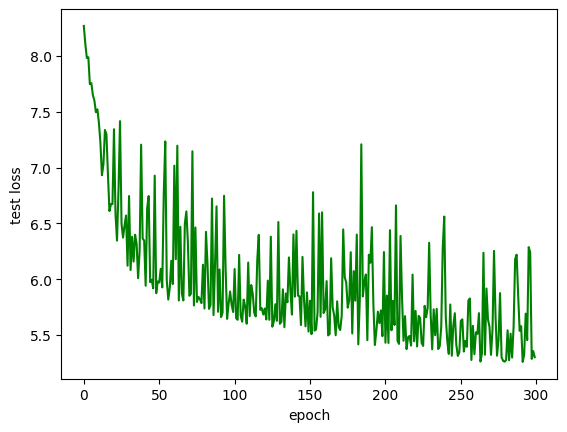

In [104]:
import matplotlib.pyplot as plt
plt.plot(np.array(test_losses), color='green', label='test loss')
plt.xlabel('epoch')
plt.ylabel('test loss')

Text(0, 0.5, 'accuracy')

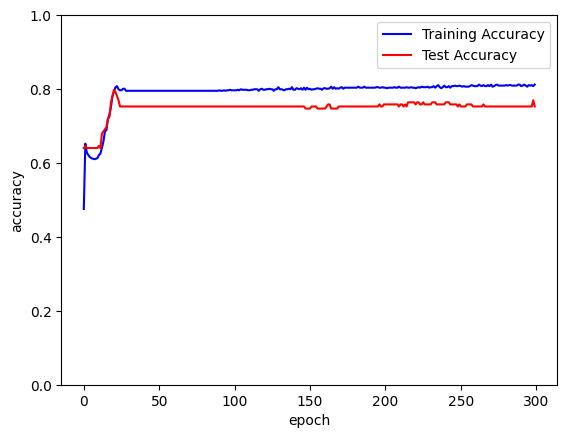

In [105]:

plt.plot(np.array(train_accuracies), color='blue', label='Training Accuracy')
plt.plot(np.array(test_accuracies), color='red', label='Test Accuracy')
# plt.scatter(test_counter, test_losses, color='red')
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('accuracy')